In [27]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas
import xarray
import cftime
import tensorflow as tf
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
datapath = 'nino34_monthly.nc'
nino34 = xarray.open_dataset(datapath, decode_times = False)
print(nino34)
nino34 = np.array((nino34['nino34'].values)[12 * 50:])

<xarray.Dataset>
Dimensions:         (bounds: 2, month: 12, time: 7800)
Coordinates:
  * time            (time) float64 15.5 45.0 74.5 ... 2.372e+05 2.372e+05
Dimensions without coordinates: bounds, month
Data variables:
    nino34          (time) float64 ...
    time_bnds       (time, bounds) float64 ...
    areacello       float32 ...
    days_per_month  (month) int32 ...


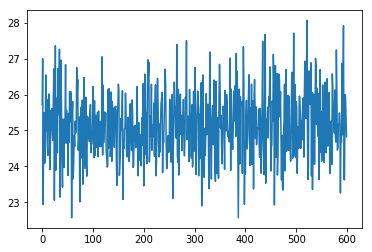

In [3]:
plt.plot(nino34[::12]);

In [4]:
def ONI(nino34, m = 3):
    oni = np.array(nino34)
    length = nino34.shape[0]
    for i in range(length):
        oni[i] = np.mean(nino34[max(0, (i - m + 1)) : min((i + 1), length)])
    return oni

In [5]:
oni = ONI(nino34)

In [6]:
def climatology(nino34):
    clm = np.zeros(12)
    length = nino34.shape[0]
    for month in range(12):
        section = [12 * i + month for i in range(length // 12)]
        clm[month] = np.mean(nino34[section])
    return clm

In [7]:
clm = climatology(nino34)

In [8]:
def SST_anomaly(nino34, clm):
    anm = np.array(nino34)
    length = nino34.shape[0]
    for i in range(length):
        anm[i] = nino34[i] - clm[i % 12]
    return anm

In [136]:
anm = SST_anomaly(nino34, clm)
oanm = ONI(anm)

# Data Preparation

In [139]:
T = 12 * 6      # prediction timeline
H = 48   # history used for prediction
signal = np.array(nino34)   # data used for training/testing
length = signal.shape[0]    # number of data points

mean = np.mean(signal)
std = np.std(signal)

signal = (signal - mean) / std

In [140]:
np.random.seed(0)

size = length - H - T       # effective dataset size
        
# create the 'history matrix'
data = np.ndarray((size, H))
for i in range(size):
    data[i] = signal[i:(i + H)]

labels = np.ndarray((size, T), dtype = np.float64)

for t in range(T):
    for i in range(size):
        labels[i,t] = anm[i + H + t]

split = size // 10      
shuffle = np.random.permutation(size)
train_ind = np.array(shuffle[0: 8 * split])
val_ind = np.array(shuffle[8 * split: 9 * split])
test_ind = np.array(shuffle[9 * split: size])

train = np.array(data[train_ind])
train_labels = np.array(labels[train_ind])

val = np.array(data[val_ind])
val_labels = np.array(labels[val_ind])

test = np.array(data[test_ind])
test_labels = np.array(labels[test_ind])

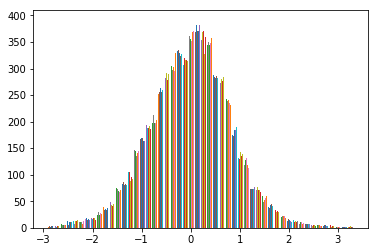

In [141]:
plt.hist(train_labels, bins=50);

# Simple Model

In [142]:
(N1, N2, N3, d) = (192, 768, 768, 0.5)
epochs = 60

model = tf.keras.models.Sequential([
                  tf.keras.layers.Dense(N1,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(N2,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(N3,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(T,  kernel_initializer='normal', activation = 'linear')
        ])

model.reset_states()

model.compile(optimizer='adam',
                    loss='mae',
                    metrics=['mse', 'mae'])

history = model.fit(train, train_labels, epochs = epochs, verbose = 0)
(loss, mse, mae) = model.evaluate(val, val_labels, verbose = 0)

print(mse, mae)

0.18781816403744583 0.31406072438773464


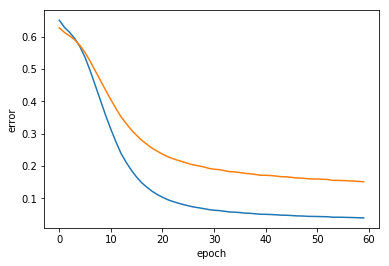

In [144]:
plt.plot(history.history['mean_squared_error']);
plt.plot(history.history['mean_absolute_error']);
plt.ylabel('error');
plt.xlabel('epoch');

In [145]:
pred = model.predict(train)

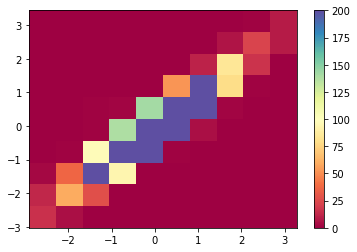

In [146]:
plt.hist2d(train_labels[:,-1], pred[:,-1], cmap = plt.cm.Spectral, vmax = 200);
plt.colorbar();

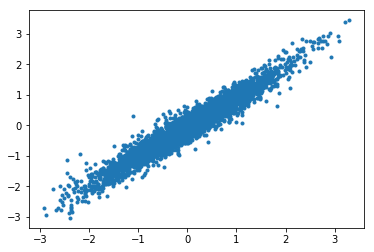

In [147]:
plt.plot(train_labels[:,-1], pred[:,-1], ".");

In [148]:
pred_val = model.predict(val)

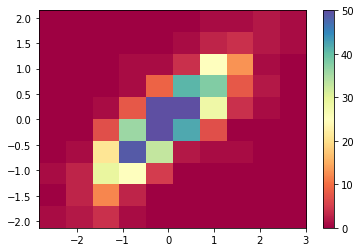

In [149]:
plt.hist2d(val_labels[:,-1], pred_val[:,-1], cmap = plt.cm.Spectral, vmax = 50);
plt.colorbar();

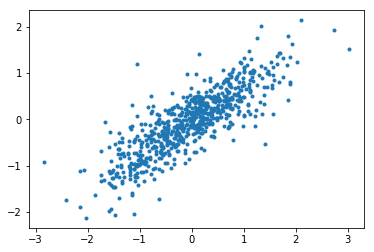

In [150]:
plt.plot(val_labels[:,-1], pred_val[:,-1], ".");

In [151]:
def correlation(x, y):
    x0 = x - np.mean(x, axis = 0)
    y0 = y - np.mean(y, axis = 0)
    return np.mean(x0 * y0, axis = 0) / np.sqrt((np.mean(x0**2, axis = 0) * (np.mean(y0**2, axis = 0))))

In [152]:
print(correlation(train_labels[:,-1], pred[:,-1]))
print(correlation(val_labels[:,-1], pred_val[:,-1]))

0.9663246421197385
0.8323037380994136


In [153]:
print(correlation(val_labels, pred_val))

[0.93802928 0.92780209 0.92250387 0.90601139 0.88416828 0.85714535
 0.85386916 0.85528194 0.84468136 0.8468757  0.85256282 0.85518795
 0.85812637 0.86041731 0.85499278 0.84854987 0.84660911 0.85043388
 0.84429333 0.83491022 0.84519357 0.86861658 0.877483   0.87541668
 0.88061867 0.87707232 0.85133136 0.83715492 0.84138441 0.83672122
 0.83826249 0.83464347 0.84561839 0.85586416 0.85568261 0.85466274
 0.8561541  0.8539227  0.85226297 0.85101575 0.85778273 0.85661853
 0.84649855 0.83542117 0.83943608 0.8515259  0.85753708 0.8653221
 0.8673897  0.87086246 0.8649707  0.86873701 0.86356208 0.8585315
 0.85206304 0.84007618 0.83865846 0.84181782 0.85159455 0.85224608
 0.86162386 0.85970566 0.85927261 0.84994405 0.84921528 0.84958944
 0.85168053 0.84490076 0.84315508 0.85677255 0.84957648 0.83230393]


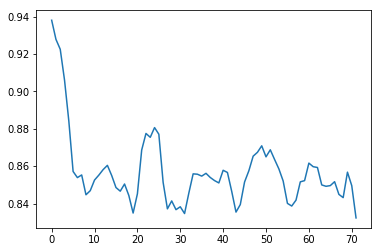

In [154]:
plt.plot(correlation(val_labels, pred_val));

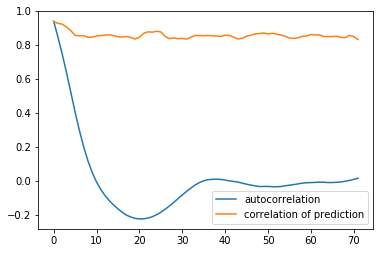

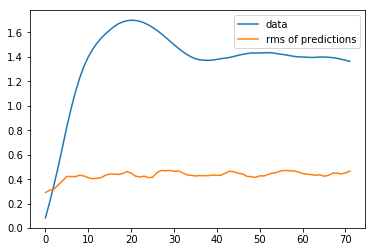

In [155]:
auto = np.zeros(T)
rms = np.zeros(T)

for t in range(T):
    auto[t] = correlation(anm[:(- t - 1)], anm[(t + 1):])
    rms[t] = mean_squared_error(anm[:(- t - 1)], anm[(t + 1):])
    
pred_rms = np.sqrt(((val_labels - pred_val)**2).mean(axis = 0))

plt.plot(auto, label = "autocorrelation");
plt.plot(correlation(val_labels, pred_val), label = "correlation of prediction");
plt.legend();
plt.figure();
plt.plot(rms, label = "data");
plt.plot(pred_rms, label = "rms of predictions")
plt.legend();